# iMaterialist (Fashion) 2019 at FGVC6 - 512
https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from util import *

In [3]:
path = Path('/home/jupyter/comp/')
# path.ls()

In [4]:
path_lbl = path/'labels'
path_img = path/'train'
path_test = path/'test'
if  not os.path.isdir(path_lbl):
    os.makedirs(path_lbl)
    
# category is in util
size = 512               # <---------------- HERE
CYCLE = 10

# get and show categories
with open(path/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]
print(label_names)

# df loading takes a while

['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']


In [5]:
# train dataframe
df = pd.read_csv(path/'train.csv')


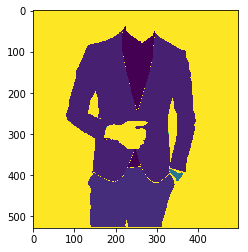

In [6]:

img_name = "53d0ee82b3b7200b3cec8c3c1becead9.jpg"

img_df = df[df.ImageId == img_name]
img_mask = ImageMask()
mask = img_mask.make_mask_img(img_df)

# img_mask = make_mask_img(img_df)
plt.imshow(mask)

# Start processing

In [7]:
images = df.ImageId.unique()    # <---------------- HERE

# Create label with dir

In [8]:
# create_label(df, images, path_lbl)

# Create Learner

In [9]:
get_y_fn = lambda x: path_lbl/f'{Path(x).stem}_P.png'


#classes = label_names
classes = list(range(category_num))
wd = 1e-2

images_df = pd.DataFrame(images)


src = (SegmentationItemList.from_df(images_df, path, folder='train')
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=classes)
       .add_test_folder('test')
     )


In [10]:
def no_tfms(self, x, size, resize_method): return x
EmptyLabel.apply_tfms = no_tfms

bs = 8
data = (src.transform(tfms=get_transforms(), size=size, resize_method=ResizeMethod.SQUISH, tfm_y=True)
       .databunch(bs=bs,num_workers=4)
        .normalize(imagenet_stats)
       )

In [11]:
# I create an accuracy metric which excludes the background pixels
# not sure if this is correct

def acc_fashion(input, target):
    target = target.squeeze(1)
    mask = target != (category_num - 1)
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

learn = unet_learner(data, models.resnet34, metrics=acc_fashion, wd=wd, )

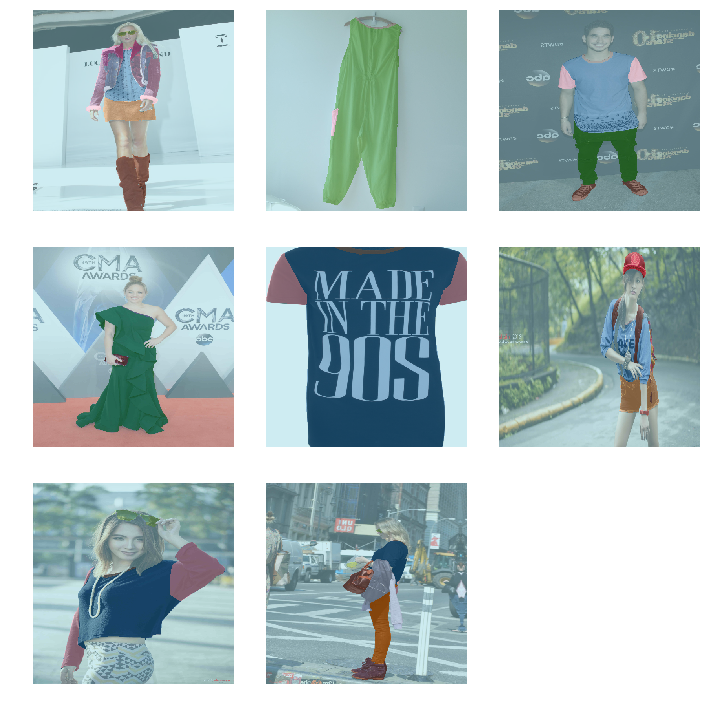

In [12]:
# look at a batch
data.show_batch(3, figsize=(10,10))

# Stop here during analysis. Training session.

In [12]:
temp = learn.load("Unfreeze-After-224")

In [13]:
learn.export()

In [14]:
learn.path

PosixPath('/home/jupyter/comp')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


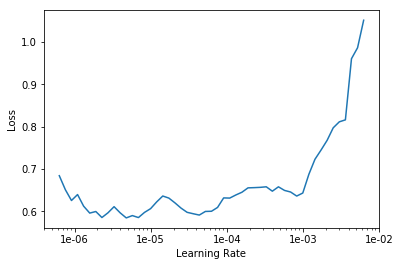

In [14]:
# find lr

lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=5e-4                                # <------------ HERE
for i in range(CYCLE):
    print("Training for {}".format(i))
    learn.fit_one_cycle(1, slice(lr), pct_start=0.9)
    learn.save('After-{0}'.format(size))


Training for 0


epoch,train_loss,valid_loss,acc_fashion,time


In [ ]:
# take a look at some results
learn.show_results()

In [ ]:
# unfreeze earlier weights
# decrease the learning rate
# train for 10 more cycles unfrozen

learn.unfreeze()
lrs = slice(lr/400,lr/4)

for i in range(CYCLE):
    print("Training for {}".format(i))
    learn.fit_one_cycle(1, slice(lr/400,lr/4) , pct_start=0.8)
    learn.save('Unfreeze After {0}'.format(size))

In [ ]:
# learn.save('After {0}'.format(size))

In [ ]:
# more results

learn.show_results()

# Do prediction & get encoded result ready for submission

In [ ]:
pred_size = 512
predicts = get_predictions(path_test, learn, pred_size)

In [ ]:
submission_df = get_submission_df(predicts)
submission_df.to_csv("./submission-{}.csv".format(size), index=False)

# TODO: 
training size & testing size should be different

In [ ]:
"{}.csv".format(size)

In [ ]:
free = gpu_mem_get_free_no_cache()
free